# Luminosity dependency of reconstruction error

In [1]:
import getpass
import h5py
import matplotlib
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import pandas as pd
import pickle

from tqdm import tqdm

In [2]:
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16, 8)

In [3]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, scores, names):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 #linestyle=line_styles[0],
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show();

In [4]:
files_dir = './fixed_files/'

ae_pred = pickle.load(open(files_dir + "ae_pred08_no_reg.p", "rb"))
ms_scores = pickle.load(open(files_dir + "ms_scores.p", "rb"))
rf_scores = pickle.load(open(files_dir + "rf_scores.p", "rb"))
true_labels = pickle.load(open(files_dir + "true_labels.p", "rb"))
inliers = pickle.load(open(files_dir + "inliers.p", "rb"))
outliers = pickle.load(open(files_dir + "outliers.p", "rb"))
luminosity = pickle.load(open(files_dir + "luminosity.p", "rb"))
X_test = pickle.load(open(files_dir + "x_test.p", "rb"))

true_labels = true_labels[0]
ms_scores = ms_scores[0]
rf_scores = rf_scores[0]
inliers = inliers[0]
outliers = outliers[0]

In [5]:
def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)

In [6]:
ae_scores = get_error_df(X_test, ae_pred, mode="topn", n_highest=100)

In [7]:
names = ["Autoencoder", "Mean square", "Random forest"]

Good lumis: 32078
Bad lumis: 659
Ratio of bad lumis: 0.0201301279897


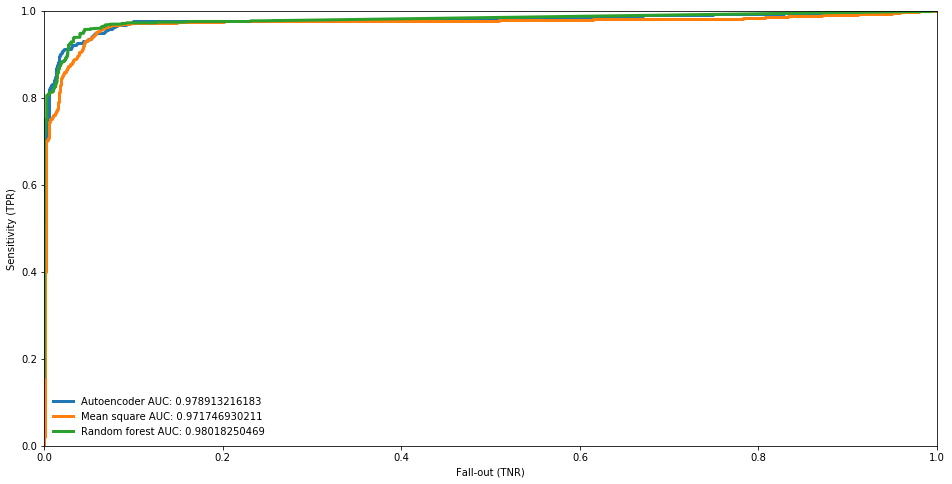

In [8]:
print("Good lumis:", inliers)
print("Bad lumis:", outliers)
print("Ratio of bad lumis:", outliers/len(true_labels))
get_roc_curve(true_labels, [ae_scores, ms_scores, rf_scores], names)

In [9]:
# Save for later
FIRST_LUMI = 130947

# Index from zero
luminosity = luminosity.reset_index(drop=True)

In [10]:
def print_lumis():
    lumi_df = pd.DataFrame({'luminosity': luminosity,
                           'true_label': true_labels})
    
    print(lumi_df[start:end].to_string())

In [11]:
def pred_vs_feature(y_val, x_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    limit=False):
    '''
    Plots two arbitrary values agains each other.
    '''
    df = pd.DataFrame({'y_val': y_val,
                       'x_val': x_val,
                       'y_class': y_class})

    groups = df.groupby('y_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.x_val, 
                group.y_val,
                color="red" if name == 1 else "blue",
                marker='o',
                ms=2,
                linestyle='',
                label= "Anomaly" if name == 1 else "Normal")

    for i in selected:
        ax.plot(x_val[i],
                y_val[i],
                color="green",
                marker='o',
                ms=4,
                linestyle='')
                 
    ax.legend()
    if not linear:
        ax.set_yscale('log')
    if limit:
        plt.xlim([limit[0], limit[1]])
    plt.grid()
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()

# Luminosity across time

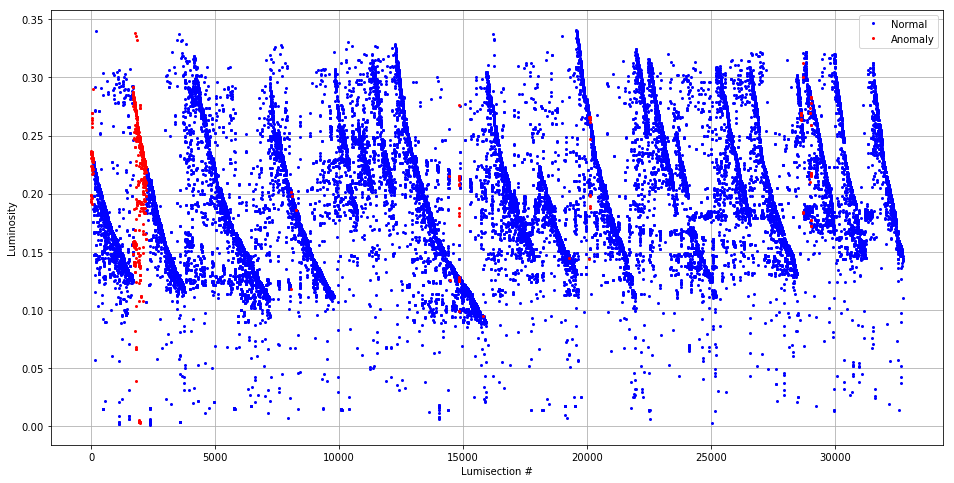

In [12]:
pred_vs_feature(luminosity, range(len(true_labels)), true_labels, "Luminosity", 
                "Lumisection #", linear=True)

# Reconstruction error across time

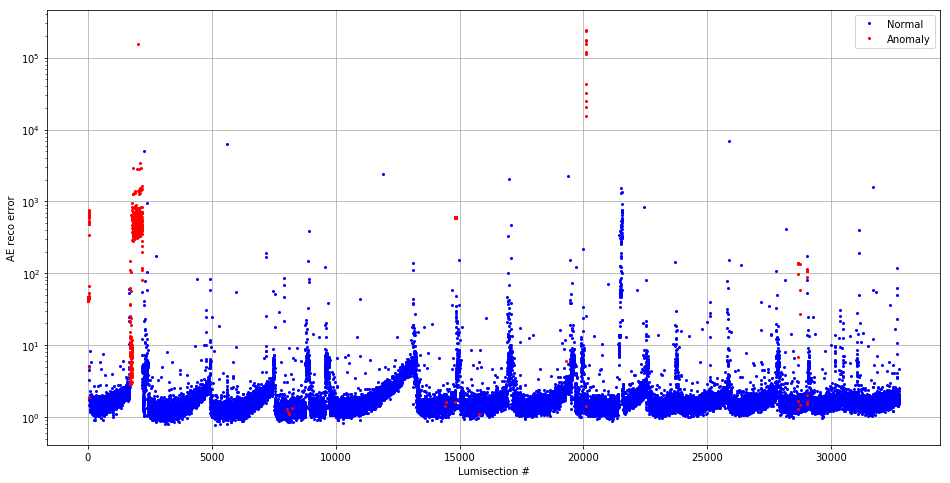

In [13]:
pred_vs_feature(ae_scores, range(len(true_labels)), true_labels, "AE reco error", 
                "Lumisection #")

## Let's try to select lumisections range of the bad lumis cluster. Selected lumisections are marked in green.

In [14]:
begin = 1850
end = 2150

lumis_range = range(begin, end)

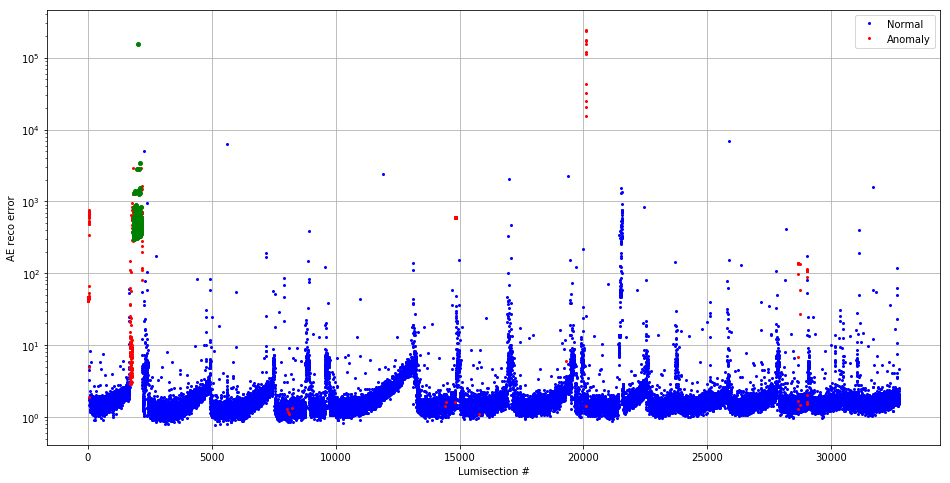

In [15]:
pred_vs_feature(ae_scores, range(len(true_labels)), true_labels, "AE reco error", 
                "Lumisection #", selected=lumis_range)

## Selected lumisections' luminosity (again in green)

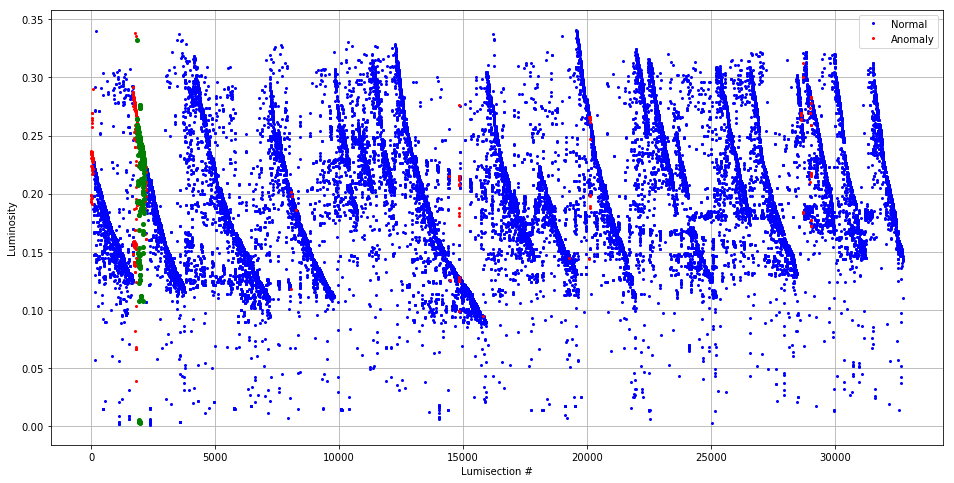

In [16]:
pred_vs_feature(luminosity, range(len(true_labels)), true_labels, "Luminosity", 
                "Lumisection #", linear=True, selected=lumis_range)

## Zoom in to the selected range:

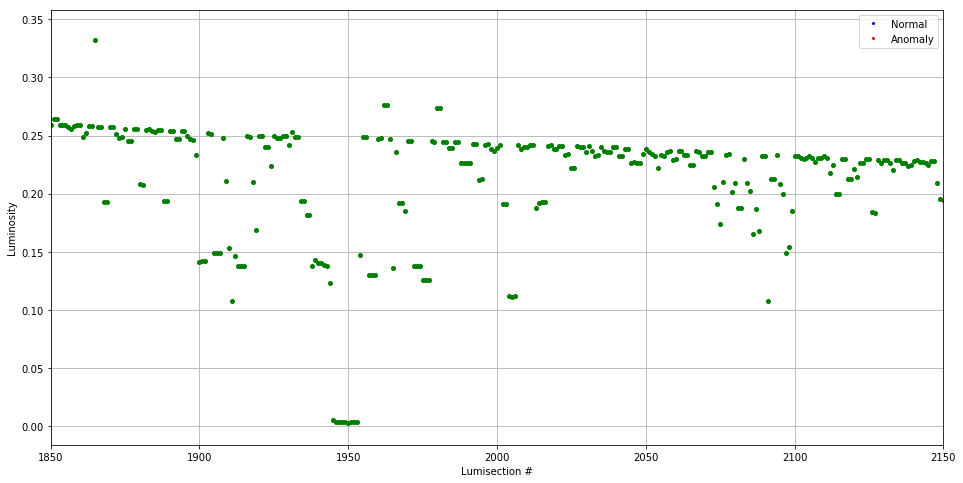

In [17]:
pred_vs_feature(luminosity, range(len(true_labels)), true_labels, "Luminosity", 
                "Lumisection #", linear=True, selected=lumis_range, limit=(begin, end))

# Histogram of luminosity of the selected lumisections

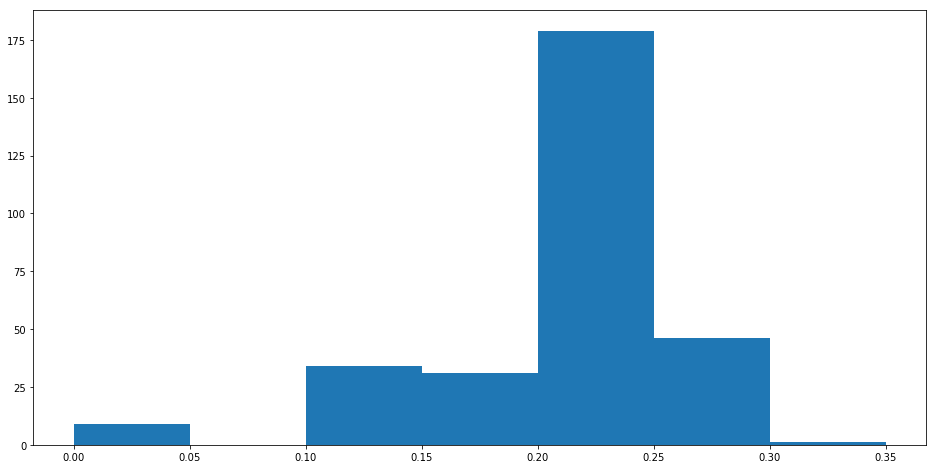

In [18]:
plt.hist(luminosity[begin:end], bins=np.arange(0, 0.4, 0.05))
plt.show()

# Reconstruction error vs luminosity

## This is plot of AE reconstruction error vs luminosity (the 'banana' in Filip's presentation)

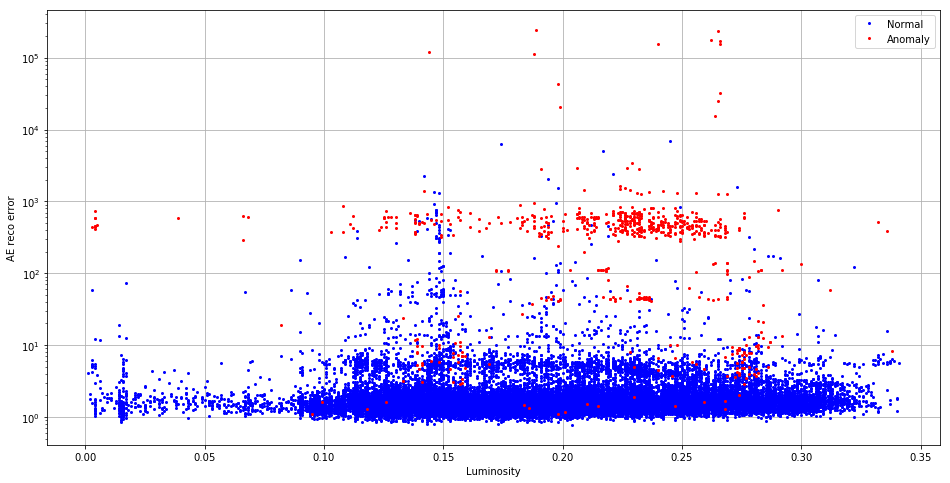

In [19]:
pred_vs_feature(ae_scores, luminosity, true_labels, "AE reco error", "Luminosity")

## ... with the cluster selected above marked in green

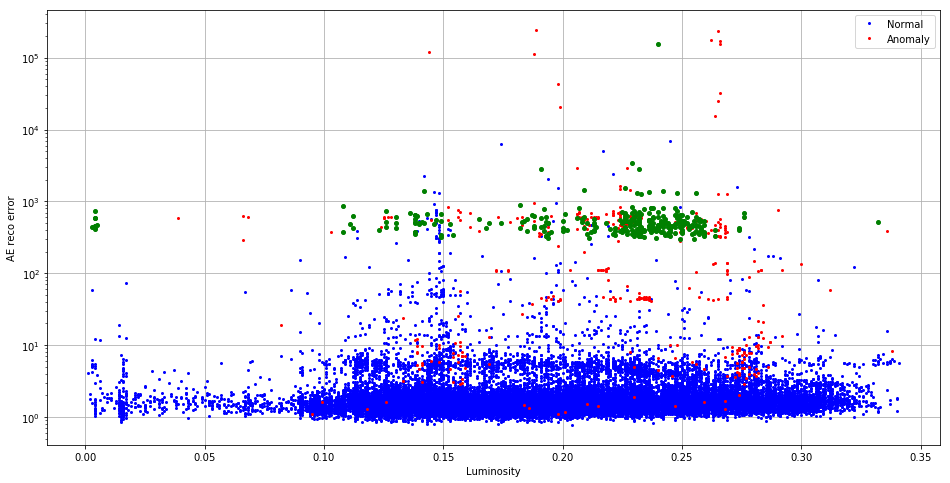

In [20]:
pred_vs_feature(ae_scores, luminosity, true_labels, "AE reco error", "Luminosity",
               lumis_range)